
# Architectural Style Classification

In [1]:
__author__ = "Caroline Ho and Cole Thomson"
__version__ = "CS230, Stanford, Autumn 2018 term"

## Contents
1. [Overview](#Overview)
2. [Set-Up](#Set-Up)
3. [Model](#Model)
5. [Resources](#Resources)

## Overview

In this notebook, we apply transfer learning to the problem of architectural style classification.

### Problem Description

Architectural style classification has broad applications, ranging from urban surveying with street view images to aiding geo-localization (determining where an image was taken). However, it presents a unique set of challenges that set it apart from typical image-based classification problems. On the one hand, buildings can have widely different forms but share the same style. For example, though the curvy Guggenheim Museum Bilbao and the blocky Dallas Wyly Theatre look very different, they are both deconstructivist buildings (Fig. 1). On the other hand, some buildings share similar forms but are of different styles. For example, the Ickworth House rotunda and the University of Virginia rotunda look fairly similar with regard to their shapes but are respectively Georgian and Palladian (Fig. 2).

![Figures](figures.png)

## Set-Up

Run the following cells to import necessary libraries/functions, set modes, and set global variables.

In [2]:
import copy
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchnet.meter as meter
import torchvision

from __future__ import print_function, division
from shutil import copyfile
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

In [3]:
%matplotlib inline
plt.ion()  # interactive mode

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Variables for data transforms
data_dir = 'arcDataset'
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
image_sizes = {'resnet': 224, 'densenet': 224, 'inception': 299}

# TODO: Add variables for model (model_name, is_fixed_feature_extraction)
num_classes = 25

In [5]:
# Set up directory for saved models
models_dir = 'classify_models'
try: os.makedirs(models_dir)
except OSError: pass

### Data

Download [Xu et al.'s architecture dataset](https://drive.google.com/file/d/0Bwo0SFiZwl3JVGRlWGZUaW5va00/edit) and place it in the current directory.

This dataset contains 4,843 images of buildings from 25 architecture style classes ranging from Achaemenid to Tudor Revival. Image dimensions/aspect ratios are not consistent.

We first transform the images in our dataset for use in our pretrained models:

In [6]:
def get_transform(model_name):
    transform = transforms.Compose([
        transforms.Resize(image_sizes[model_name]),
        transforms.CenterCrop(image_sizes[model_name]),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    return transform

In [7]:
# TODO: Delete this once experiments finish running.
dataset = datasets.ImageFolder(data_dir, transform=get_transform('resnet'))
inception_dataset = datasets.ImageFolder(data_dir, transform=get_transform('inception'))

We now create an 80/10/10 train/dev/test split.

In [8]:
# Sets up samplers for train/dev/test split.
def create_samplers(train_percent=0.8):
    random.seed(0)
    indices = list(range(len(dataset)))
    random.shuffle(indices)
    
    train_split = int(train_percent * len(indices))
    dev_percent = (1 - train_percent) / 2
    dev_split = int((train_percent + dev_percent) * len(indices))
    train_indices = indices[:train_split]
    dev_indices = indices[train_split:dev_split]
    test_indices = indices[dev_split:]

    samplers = {
        'train': torch.utils.data.SubsetRandomSampler(train_indices),
        'dev': torch.utils.data.SubsetRandomSampler(dev_indices),
        'test': torch.utils.data.SubsetRandomSampler(test_indices)
    }
    return samplers

In [9]:
samplers = create_samplers()
dataloaders = {x: torch.utils.data.DataLoader(dataset, batch_size=4, sampler=samplers[x], num_workers=4)
               for x in ['train', 'dev', 'test']}
inception_dataloaders = {x: torch.utils.data.DataLoader(inception_dataset, batch_size=4, sampler=samplers[x], num_workers=4)
               for x in ['train', 'dev', 'test']}
dataset_sizes = {x: len(samplers[x]) for x in ['train', 'dev', 'test']}
class_names = dataset.classes

Let's visualize some images from our training set.

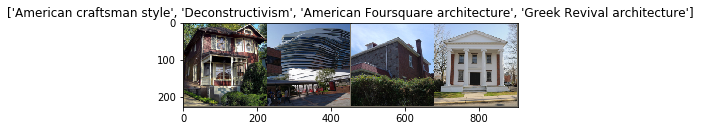

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Model

We shall test fine-tuning and fixed feature extraction in our models to classify architecture.

In [11]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'dev']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients.
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    if isinstance(outputs, tuple):
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'dev' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best dev Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [12]:
def test_model(model, dataloaders):
    model.eval()
    confusion_matrix = meter.ConfusionMeter(num_classes)
    corrects = 0

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            confusion_matrix.add(preds, labels.data)

    acc = corrects.double() / dataset_sizes['test']
    print('Test Acc: {:4f}'.format(acc))
    return model, confusion_matrix.value()

In [13]:
def visualize_model(model, dataloaders, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [14]:
def visualize_confusion_matrix(confusion_matrix):
    confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    
    cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(16, 12))
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=90)
    plt.yticks(tick_marks, class_names)
    
    thresh = confusion_matrix.max() / 2
    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(j, i, format(confusion_matrix[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if confusion_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

### Experiments

In [15]:
def create_model(model_name, training_style):
    model = None
    if model_name == 'densenet':
        model = models.densenet201(pretrained=True)
        if training_style == 'ffe':
            for param in model.parameters():
                param.requires_grad = False
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)
        loaders = dataloaders
    elif model_name == 'resnet':
        model = models.resnet152(pretrained=True)
        if training_style == 'ffe':
            for param in model.parameters():
                param.requires_grad = False
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
        loaders = dataloaders
    elif model_name == 'inception':
        model = models.inception_v3(pretrained=True)
        if training_style == 'ffe':
            for param in model.parameters():
                param.requires_grad = False
        num_aux_ftrs = model.AuxLogits.fc.in_features
        model.AuxLogits.fc = nn.Linear(num_aux_ftrs, num_classes)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
        loaders = inception_dataloaders
    model = model.to(device)
    return model, loaders

In [ ]:
model_names = ['densenet', 'resnet', 'inception']
training_styles = ['ffe', 'ft']  # fixed feature extraction, fine-tuning

for model_name in model_names:
    for training_style in training_styles:
        print('Model: ' + model_name)
        print('Training Style: ' + str(training_style))
        model, loaders = create_model(model_name, training_style)
        
        model_path = os.path.join(models_dir, model_name + '_' + training_style + '.pth')
        if not os.path.exists(model_path):
            optimizer = optim.Adam(model.parameters())
            train_model(model, loaders, nn.CrossEntropyLoss(), optimizer,
                        lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1))
            torch.save(model.state_dict(), model_path)
        else:
            model.load_state_dict(torch.load(model_path))
        
        if model_name == 'inception': model.aux_logits = False
        model, confusion_matrix = test_model(model, loaders)
        visualize_model(model, loaders)
        visualize_confusion_matrix(confusion_matrix)

|Model|Dev Accuracy|Test Accuracy|
|-|-|-|
|DenseNet (FFE)|0.x|0.x|
|DenseNet (FT)|0.x|0.x|
|ResNet (FFE)|0.x|0.x|
|ResNet (FT)|0.x|0.x|
|Inception (FFE)|0.x|0.x|
|Inception (FT)|0.x|0.x|

## Acknowledgements & Resources

- Much of the transfer learning code for this notebook is taken from the [PyTorch Transfer Learning Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) and the [Finetuning Torchvision Models Tutorial](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html).
- [Confusion Matrix](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)